# 771948_A23_T3A - Group Work Assignment #
# Task 2 - Multi-label image-based digit classification problem #
## Assignment by Chris Mintz 202369825 and Antonia Agunbiade 202375309 ##

---
### Additional notes from class chat ###
#### 1. Labels from dataset will be folder names
#### 2. Beware of the multi image model classifying into triplets instead of single digits. The output shape should be 1000 instead of 10
#### 3. DO NOT recombine the split data. It has to be used as is as per TA Khadjia
#### 4. From Khadjia: The provided splits into training, validation and testing were designed to simulate real-world scenarios. Teams must develop a baseline model using these splits and gthen improve upon this baseline through various techniques such as preprocessing and model architecture enhancements.
---

# Task 6 - Load and preprocess the dataset for multi-label image-based digit classification task

## <b>References</b>

Johns, Ray. (2024). PyTorch vs TensorFlow for your Python Deep Learning Project. Available at: https://realpython.com/pytorch-vs-tensorflow/. [Accessed Aug 5, 2024]

In [109]:
# For this assignment we have chosen to use the TensorFlow over PyTorch as TensorFlow 2.0 has eager execution and the Keras APIs have more prefabricated components for us to use.
import tensorflow as tf
# TO DO: we might be able to remove this global import
from tensorflow import keras
# Needed for image pre-processing
from PIL import Image
# there is a lint problem access problem with the latest release of TensorFlow/Keras so we have to go direct to the root call
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input
# we want these for some visualizations
import matplotlib.pyplot as plt
import numpy as np
# for image processing
import os
# for progress bars
from tqdm import tqdm

# Change directory location as needed. This should be the root of the unzipped dataset and the initial folder visible shuold be "triple_mnist" 
# -------------------------------------------
dataset_root_dir = 'z:'
log_dir = dataset_root_dir + '\\logs'
# -------------------------------------------

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Define our data split directory locations
training_dir = dataset_root_dir + '\\triple_mnist\\train'
validate_dir = dataset_root_dir + '\\triple_mnist\\val'
test_dir = dataset_root_dir + '\\triple_mnist\\test'

# mode switch for label encoding
#class_mode_default = 'categorical' # or sparse
class_mode_default = 'sparse' # or categorical
#loss_mode_default = 'categorical_crossentropy' # or sparse_categorical_crossentropy
loss_mode_default = 'sparse_categorical_crossentropy' # or categorical_crossentropy


# Define our image parameters
image_height = 84
image_width = 84
batch_size = 64
# these are grayscale images, so we will only have 1 channel and this will be enforced in the data loading process
channels = 1
# output classes will be 0 to 9 which = 10
num_classes = 10
#TODO: Optimize
epochs = 10

# Data augmentation and preprocessing parameters to initialize the ImageDataGenerator
# Transformations we are NOT using include: zoom_range, horizontal_flip, vertical_flip, fill_mode, channel_shift_range, brightness_range, zca_epsilon, zca_whitening
# Note that we had the opportunity to use the "preprocessing_function" parameter to crop the images as needed but we chose to persist the cropped images to disk to prevent
# this function from being called with each epoch. This is because the cropping function is computationally expensive and we only need to do it once.
idg = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    shear_range=0.2,         # Apply shear transformations
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,   # Randomly shift images vertically by up to 20% of the height
)

## Pre-processing to get the triplet digit data into single values
### The data came to us as a series of triplet hand written numbers meaning that in the 84 x 84 image there are three images. Upon inspection there is a clean divide between all digits despite them having random y placement in the frame. Our best approach is to take the file name, divide the image into three and then save out the single hand written digit to a new folder. To manage this in memory could be costly so we will check if the images exist on your disk, write them if necessary, but read them from pre-processesd state if they have already been cleaned in your local dataset. We will watch for images that get cropped but even that might be only a couple of pixels.

In [110]:
# --------------------------------------------------------------------------
# this is the function will crop a triplet digit image into three separate images and return them as a list of three images.
# this function does not manage disk persistence, it is only for in-memory processing
def crop_image(image):
    image_return = []
    x_cropsize = 28
    y_cropsize = 84
    x_croplength = x_cropsize/2
    y_croplength = y_cropsize/2
    # define the centers of the three cropped images and the crop size will go to the edge coords from there
    x_centers = [14, 42, 70]
    y_centers = [42, 42, 42]
    # create the three cropped images
    image_return = [None, None, None]
    for i in range(3):
        image_return[i] = image.crop((x_centers[i]-x_croplength, y_centers[i]-y_croplength, x_centers[i]+x_croplength, y_centers[i]+y_croplength))
        
    return image_return

# --------------------------------------------------------------------------
# this function lets us look at our images in the datasets
# let's peek into the dataset by loading the first batch of num_to_show images
def datset_peek(idg_show: ImageDataGenerator, num_to_show: int):

        fig, ax = plt.subplots(1, num_to_show, figsize=(10, 10))
        for i in range(num_to_show):
            ax[i].imshow(np.squeeze(idg_show[0][0][i]), cmap='gray')
            if class_mode_default == 'categorical':
                # convert the one-hot encoded label back to the original label
                ax[i].set_title(f'Lbl: {np.argmax(idg_show[0][1][i])}')
            else:
                 ax[i].set_title(f'Lbl: {int(idg_show[0][1][i])}')
            ax[i].axis('off')
        plt.show()

In [111]:
#--------------------------------------------------------------------------
def process_triplets(processing_path: str, preprocessing_completed_path: str, test_mode: bool = False) -> int:
    # this function will process the triplet images in the processing_path and crop them into individual images and save them to the preprocessing_completed_path
    """
    Parameters:
    processing_path: the path to the folder containing the triplet MNIST images.
    preprocessing_completed_path: the path to the folder where the cropped images will be saved. This path will be created for you in the process.
    test_mode: if True, the function will only process the first folder in the processing_path. This is useful for initial testing of the function. Once done testing, delete the preprocessing folders and re-run with this flag removed. 
    Returns:
    int: the number of files created in the preprocessing_completed_path
    """
    # instead of looking to disk for each instance of the new file to find out the name, we're going to keep an in-memory index of the files we've created
    cropped_index = [0,0,0,0,0,0,0,0,0,0]
    files_created = 0 # running total of all triplet files loaded
    all_folders = os.listdir(processing_path)
    # Enumerate and load the directories
    for index, image_folder in enumerate(tqdm(all_folders, desc=f'processing folders in the {processing_path} directory')):
        triplet_images = [] # a list of the images in the current folder 
        # now go through each directory and get the images
        curr_files = os.listdir(os.path.join(processing_path, image_folder))
        for image_file in curr_files:
            file_path = os.path.join(processing_path, image_folder, image_file)
            try:
                image = Image.open(file_path)
                triplet_images.append(image)
                ##print(f'folder index {index}: {image_file} loaded successfully from {file_path}.')
            except PermissionError as e:
                print(f'Permission denied, please launch your IDE as admin: {e}')
            except Exception as e:
                print(f'An error occurred: {e}')
        # now we have all the images in the folder, let's crop them
        crop_labels = list(image_folder)
        # loop through current triplet_images and pass to the crop_image function
        cropped_images = []
        for image in triplet_images:
            cropped_images = crop_image(image)
            # now we need to save these images to disk
            for i in range(3):
                # if this is the first time we've written to this label, we need to create the folder
                if int(cropped_index[int(crop_labels[i])]) == 0:
                    os.makedirs(os.path.join(preprocessing_completed_path, crop_labels[i]), exist_ok=True)
                cropped_images[i].save(os.path.join(preprocessing_completed_path, crop_labels[i], f'{cropped_index[int(crop_labels[i])]}_{crop_labels[i]}.png'))
                # increment the index for the label for the next image
                cropped_index[int(crop_labels[i])] += 1
                files_created += 1
        if test_mode:
            break # iterate only the first folder
    return files_created

In [112]:
# WARNING - this code commits 300,000 files to your file drive and will take a long time to run - you can monitor progress at the bottom of the cell
# Check and see if the triplet images have been cropped and saved to your drive
training_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\train_preprocessed'
validate_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\val_preprocessed'
test_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\test_preprocessed'
if os.path.exists(training_preprocessed_dir):
    print('Training preprocessed images exist')
else:
    process_triplets(training_dir, training_preprocessed_dir)

if os.path.exists(validate_preprocessed_dir):
    print('Validation preprocessed images exist')
else:
    process_triplets(validate_dir, validate_preprocessed_dir)

if os.path.exists(test_preprocessed_dir):
    print('Test preprocessed images exist')
else:
    process_triplets(test_dir, test_preprocessed_dir)

Training preprocessed images exist
Validation preprocessed images exist
Test preprocessed images exist


In [113]:
# Load the images from a locally mapped source (see README.md for details on setting up local drive mapping)
# We've used the idg to load only the training images and preprocess them with the above parameters
# Images are brought in as grayscale (single channel) as they are black and white images
print('generating training set')
training_generator = idg.flow_from_directory(
    training_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print('generating test set')
# Our test and validation data should not be augmented so their init is simpler and does not use our predefined idg parameters
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print('generating validation set')
# Note use of validation data but no augmentation
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validate_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print(f'label sanity peek on training set: {training_generator.labels}')

generating training set
Found 192000 images belonging to 10 classes.
generating test set
Found 60000 images belonging to 10 classes.
generating validation set
Found 48000 images belonging to 10 classes.
label sanity peek on training set: [0 0 0 ... 9 9 9]


In [114]:
# check and see if all the images are the same shape before feeding them into the model
print(f'training generator shape {training_generator.image_shape}')
print(f'validation generator shape {validation_generator.image_shape}')
print(f'test generator shape {test_generator.image_shape}')


training generator shape (84, 84, 1)
validation generator shape (84, 84, 1)
test generator shape (84, 84, 1)


# Task 7 - Build a convultional neural network (CNN) model for the multi-label image-based digit classification task

In [115]:
# --------------------------------------------------------------------------
# this function keeps our baseline model reusable and easy to modify
def create_model(optimizer='adam', loss=loss_mode_default, metrics=['accuracy']):
    """
    Parameters:
    optimizer: the optimizer to use in the model
    loss: the loss function to use in the model
    metrics: the metrics to use in the model
    Returns:
    model: a compiled Keras model
    """
    #TODO: Don't forget to use Dropout layers to prevent overfitting
    # Model setup
    model = Sequential()
    model.add(Input(shape=(image_height, image_width, channels)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.50))
    # Adjust the final layer to match the target shape
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model using the parameters passed in
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# Show the model summary and ensure the final layer count matches our desired output of 10 as defined in the final Dense layer.
model = create_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 82, 82, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 53792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     6,885,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,887,114 (26.27 MB)

 Trainable params: 6,887,114 (26.27 MB)

 Non-trainable params: 0 (0.00 B)

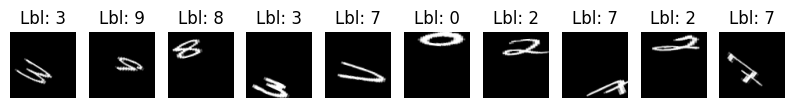

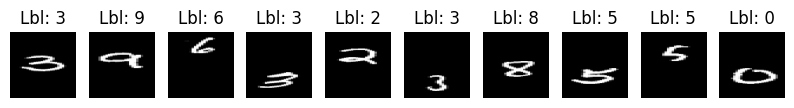

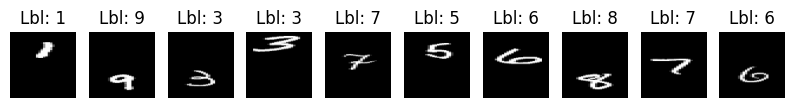

In [116]:
datset_peek(training_generator, 10)
datset_peek(validation_generator, 10)
datset_peek(test_generator, 10)

In [105]:
# trying TensorBoard which will be a callback to an external callback
# I'm not sure a directory check is needed here, but it's a good habit to get into
if os.path.exists(log_dir) is not True:
        os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

planned_epochs = 100
training_steps_per_epoch = training_generator.samples // batch_size // 100
validation_steps_per_epoch = validation_generator.samples // batch_size // 100

print('training samples:', training_generator.samples)
print('validation samples:', validation_generator.samples)

print('batch_size:', batch_size)

print('planned epochs:', planned_epochs)
print('training steps per epoch:', training_steps_per_epoch)
print('validation steps per epoch:', validation_steps_per_epoch)

# model training time and we'll hold on to history for visualization
history = model.fit(
        training_generator,
        steps_per_epoch=training_steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps_per_epoch,
        epochs=planned_epochs,
        verbose=1,
        callbacks=[tensorboard_callback])


training samples: 192000
validation samples: 48000
batch_size: 64
planned epochs: 100
training steps per epoch: 30
validation steps per epoch: 7
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5436 - loss: 1.2841 - val_accuracy: 0.6205 - val_loss: 1.0738
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5410 - loss: 1.3027 - val_accuracy: 0.3973 - val_loss: 1.8246
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5868 - loss: 1.3055 - val_accuracy: 0.4464 - val_loss: 1.8160
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5665 - loss: 1.2877 - val_accuracy: 0.4643 - val_loss: 1.7330
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5623 - loss: 1.2287 - val_accuracy: 0.4554 - val_loss: 1.8433
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5570 - loss: 1.2340 - val_accuracy: 0.4777 - val_loss: 1.6869
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5594 - loss: 1.3111 -

# Task 8 - Fine-tune the CNN model using appropriate techniques like hyperparameter tuning, cross-validation, etc

## <b>References:</b>
TensorFlow. (Jan 6, 2022). Hyperparameter tuning with the HParams Dashboard. Available online at: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams#:~:text=Hyperparameter%20Tuning%20with%20the%20HParams%20Dashboard%201%201.,Visualize%20the%20results%20in%20TensorBoard%27s%20HParams%20plugin%20 [Accessed on Aug 20, 2024]

In [ ]:
def create_hp_params_model(hparams, loss=loss_mode_default, metrics=['accuracy']):
    model = Sequential()
    model.add(Input(shape=(image_height, image_width, channels)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hparams[hp_dropout]))
    model.add(Flatten())
    model.add(Dense(hparams[hp_num_units], activation='relu'))
    model.add(Dropout(hparams[hp_dropout]))
    # Adjust the final layer to match the target shape
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model using the parameters passed in
    model.compile(optimizer=hparams[hp_optimizer], loss=loss, metrics=metrics)

    # include the callback directly with the log metrics
    hp_history = model.fit(
        training_generator,
        steps_per_epoch=training_steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps_per_epoch,
        epochs=planned_epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.TensorBoard(log_dir),  # log metrics
            hp.KerasCallback(log_dir, hparams),  # log hparams
            ]
        )
    accuracy = model.evaluate(test_generator)
    return accuracy


# hyperparameter tuning
# import the hyperparameter tuning specific libraries
from tensorboard.plugins.hparams import api as hp

hp_num_units = hp.HParam('num_units', hp.Discrete([32, 64, 128]))
hp_dropout = hp.HParam('dropout', hp.RealInterval(0.1, 0.25))
hp_optimizer = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))
metric_accuracy = 'accuracy'

with tf.summary.create_file_writer(dataset_root_dir + '\\logs\\hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[hp_num_units, hp_dropout, hp_optimizer],
        metrics=[hp.Metric(metric_accuracy, display_name='Accuracy')],
    )


session_num = 0

for num_units in hp_num_units.domain.values:
  for dropout_rate in (hp_dropout.domain.min_value, hp_dropout.domain.max_value):
    for optimizer in hp_optimizer.domain.values:
      hparams = {
          hp_num_units: num_units,
          hp_dropout: dropout_rate,
          hp_optimizer: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      create_hp_params_model(hparams)
      #run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [121]:
import numpy as np
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Function to create model, required for KerasClassifier
def create_k_model(optimizer='adam', dropout_rate=0.0, num_units=64):
    model = Sequential()
    model.add(Dense(num_units, input_dim=8, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, epochs=10, batch_size=batch_size, verbose=1)

# Define the hyperparameter space
param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'num_units': [16, 32, 64, 128],
    'epochs': [10, 20, 30],
    'batch_size': [10, 20, 30]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1)

# Example data
X = np.random.rand(100, 8)  # 100 samples, 8 features
y = np.random.randint(0, 2, 100)  # 100 samples, binary target

# Fit the RandomizedSearchCV object to the data
random_search_result = random_search.fit(X, y)

# Print the best score and hyperparameters
print(f"Best Score: {random_search_result.best_score_}")
print(f"Best Hyperparameters: {random_search_result.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: Invalid parameter num_units for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(num_units=32)`
Check the list of available parameters with `estimator.get_params().keys()`

In [83]:
# cross validation
# NOTE: scikeras must be installed for this to work - uncomment next line if you have never installed it
#%pip install scikeras
# import the KerasClassifier from keras and RandomizedSearchCV from scikeras.wrappers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV

# wrap the model in the KerascClassifier
model = KerasClassifier(model=create_model, epochs=10, batch_size=batch_size, verbose=1)

# Define the hyperparameter grid
param_grid = {
    'model__optimizer': ['rmsprop', 'adam', 'adamax'],
    'model__init': ['glorot_uniform', 'normal', 'uniform'],
    'model__epochs': [1, 2, 3],
    'model__batch_size': [10, 20, 30]
}

# Perform cross-validation using RandomizedSearchCV
kfold = KFold(n_splits=2, shuffle=True)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=2, cv=kfold, verbose=1)
random_search_result = random_search.fit(training_generator)
#random_search_result = random_search.fit(
#    training_generator,
#    steps_per_epoch=training_generator.samples // batch_size,
#    epochs=1,
#    validation_data=validation_generator,
#    validation_steps=validation_generator.samples // batch_size,
#    verbose=1,
#    callbacks=[tensorboard_callback])

# Print the best score and parameters
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")


Fitting 2 folds for each of 2 candidates, totalling 4 fits


KeyboardInterrupt: 

# Task 9 - Visualize the dataset and the CNN model's results where applicable with feature maps, learning curves, etc

## <b>References</b>
TensorFlow. (Oct 25, 2023). Get started with TensorBoard | TensorFlow. Available online at: https://www.tensorflow.org/tensorboard/get_started. [Accessed Aug 20, 2024] 

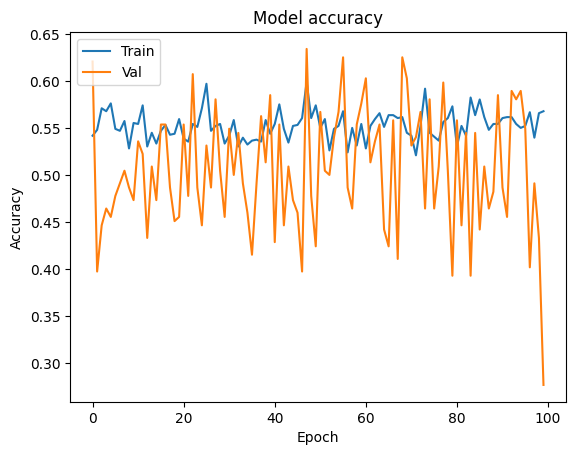

In [106]:
# NOTE: TensorBoard epoch data can be viewed by running the following command in the terminal: tensorboard --logdir=logs
# where the logs directory is written at dataset_root_dir + '\\logs'
# a browser window will open with the TensorBoard data to show how training is proceeding or final model results are available below

# Plot training & validation accuracy based on each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [95]:
# Also want to try a little interactive plot
import plotly.graph_objs as go
from plotly.offline import iplot
# history var should still contain training data as before
# Create traces
trace0 = go.Scatter(
    x = history.epoch,
    y = history.history['accuracy'],
    mode = 'lines',
    name = 'Accuracy'
)
trace1 = go.Scatter(
    x = history.epoch,
    y = history.history['loss'],
    mode = 'lines',
    name = 'Loss'
)
# Plot and embed in notebook
iplot([trace0, trace1]) 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Task 10 - Report the final performance of the CNN model using appropriate performance metrics like accuracy, F1-score, etc

# Task 11 -Decide on the best model for classification and CNN architecture for digital recognition